In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
df = pd.read_csv("../../data/space-track-gp/gp_20201214.csv.gz")
df['LAUNCH_DATE'] = pd.to_datetime(df['LAUNCH_DATE'], format='%Y-%m-%d')
df['DECAY_DATE'] = pd.to_datetime(df['DECAY_DATE'], format='%Y-%m-%d')

In [5]:
df['EPOCH'].head()

0    2020-12-12T15:16:44.294592
1    2020-11-13T20:25:31.231488
2    2020-11-21T03:46:46.331616
3    2020-12-06T10:55:57.922464
4    2020-12-12T16:01:48.374400
Name: EPOCH, dtype: object

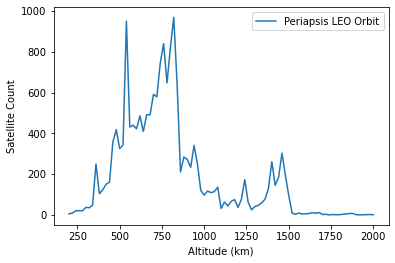

In [3]:
cross_counts = {}
in_counts = {}
peri_counts = {}
bin_size = 20
tolerance = 0

for alt in np.arange(200,2000+bin_size,bin_size):
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_counts[alt] = cross_count
    in_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    in_counts[alt] = in_count
    peri_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) & (df['DECAY_DATE'].isnull())])
    peri_counts[alt] = peri_count
    

plt.figure()
x = cross_counts.keys()
y1 = cross_counts.values()
y2 = in_counts.values()
y3 = peri_counts.values()
#plt.plot(x,y1, label='Cross Orbit')
#plt.plot(x,y2, label='In Orbit')
plt.plot(x,y3, label='Periapsis LEO Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Satellite Count")
plt.legend()
plt.show()

$Sphere Area = 4*\pi*r^2$

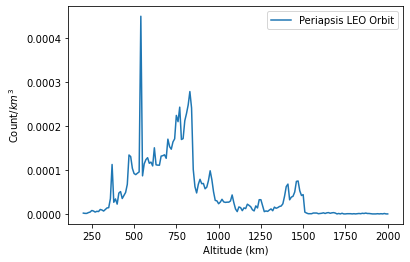

In [4]:
cross_density = {}
in_density = {}
peri_density = {}
earth_radius = 6371
bin_size = 10
tolerance = 0


for alt in np.arange(200,2000+bin_size,bin_size):
    spatial_vol = 4*np.pi*(earth_radius+alt+bin_size)**2 - \
                  4*np.pi*(earth_radius+alt)**2
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_density[alt] = cross_count / spatial_vol
    in_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    in_density[alt] = in_count / spatial_vol
    peri_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & 
                        (df['PERIAPSIS']<=alt+bin_size+tolerance) &
                        (df['MEAN_MOTION']>11.25) &
                        (df['ECCENTRICITY']<0.25) &
                        (df['DECAY_DATE'].isnull()) &
                        #((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > 2010)) &
                        (df['LAUNCH_DATE'].notnull()) 
                        #& (df['LAUNCH_DATE'] <= '2010-04-20')
                        #& (df['LAUNCH_DATE'] <= '2016-02-01')
                       ])
    peri_density[alt] = peri_count / spatial_vol

plt.figure()
x = cross_density.keys()
y1 = cross_density.values()
y2 = in_density.values()
y3 = peri_density.values()
#plt.plot(x,y1, label='Cross Orbit')
#plt.plot(x,y2, label='In Orbit')
plt.plot(x,y3, label='Periapsis LEO Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.legend()
plt.show()

In [31]:

earth_radius = 6371
bin_size = 10
bins = np.arange(200,2000+bin_size,bin_size)
built_df = pd.DataFrame()
start = int(df['LAUNCH_DATE'].dt.year.min())
df = df.dropna(subset=['LAUNCH_DATE'])
df['ALT_BIN'] = pd.cut(df['PERIAPSIS'], bins=bins, labels=bins[:-1])

for y in np.arange(start,2021):
    tmp_df = df[(df['MEAN_MOTION']>11.25) &
                (df['ECCENTRICITY']<0.25) &
                ((df['DECAY_DATE'].isnull()) | (df['DECAY_DATE'].dt.year > y+2)) &
                (df['LAUNCH_DATE'].dt.year <= y)].groupby('ALT_BIN')['CCSDS_OMM_VERS'].count().reset_index()
    tmp_df.columns = ['ALT','ALL_COUNT']
    tmp_df['YEAR'] = y
    built_df = pd.concat([built_df,tmp_df])

built_df['ALL_DENSITY'] = built_df.apply(lambda x: x['ALL_COUNT'] / (4*np.pi*(earth_radius+x['ALT']+bin_size)**2 - 4*np.pi*(earth_radius+x['ALT'])**2), axis=1)


fig = px.line(built_df, x="ALT", y="ALL_DENSITY", title='Satellite Density Across Years',
              animation_frame="YEAR", range_x=[200,2000], range_y=[0,0.0005])
fig.show()

In [34]:
@gif.frame
def make_gif(built_df, y):
    df = built_df[built_df['YEAR']==y]

    fig = px.line(df, x="ALT", y="ALL_DENSITY", title=f'Satellite Density Year {y}',
                  range_x=[200,2000], range_y=[0,0.0005])
    
    return fig

frames = []
for y in np.arange(start,2021):
    frame = make_gif(built_df, y)
    frames.append(frame)
gif.save(frames, './spatial.gif', duration=100)